In [1]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from tensorflow.keras.utils import plot_model

# Load Bert

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [3]:
train_data_df = pd.read_csv("data/twitter-2016train-BD.txt", delimiter='\t', header=None, names=['id','topic','label', 'tweet'])
val_data_df = pd.read_csv("data/twitter-2016devtest-BD.txt", delimiter='\t', header=None, names=['id','topic','label', 'tweet'])

train_tweet = train_data_df.tweet.values
train_topic = train_data_df.topic.values
y_train = train_data_df.label.values

val_tweet = val_data_df.tweet.values
val_topic = val_data_df.topic.values
y_val = val_data_df.label.values

In [4]:
print(train_data_df.sample(5))

                      id          topic     label  \
1670  640767829097103360     disneyland  positive   
676   639046234817167360          barca  positive   
2382  628910685829890049  grateful dead  positive   
98    634728000702021632          ac/dc  positive   
2533  641001036178685952         harper  negative   

                                                  tweet  
1670  I think I'm starting to get sick &amp; it's no...  
676   Real Madrid get better of De Gea saga, Barca g...  
2382  Check it out Saturday - Grateful Dead songs, w...  
98    Red Sox game I have tickets to tonight may get...  
2533  @Lawson890 @AdamRubinESPN @msimonespn @ynscspd...  


In [5]:
train_labels=[]
val_labels=[]
label_dict = {'negative':0,'positive':1}

for label in y_train:
    train_labels.append(label_dict[label])

for label in y_val:
    val_labels.append(label_dict[label])

In [6]:
print(len(train_labels))
print(len(val_labels))

4309
1417


# Data preprocessing

In [7]:
def processdata(topics,tweets,labels):
  input_ids = []
  attention_masks = []
  token_type_ids = []
  for topic, tweet in zip(topics,tweets):
    encoded_dict = tokenizer.encode_plus(topic,
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                        return_token_type_ids = True,
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  token_type_ids = torch.cat(token_type_ids,dim=0)
  labels = torch.tensor(labels)
  return input_ids,attention_masks,token_type_ids,labels

In [8]:
train_input_ids,train_attention_masks,train_token_type_ids,train_labels = processdata(train_topic,train_tweet,train_labels)
val_input_ids,val_attention_masks,val_token_type_ids,val_labels = processdata(val_topic,val_tweet,val_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
F:\anaconda\envs\lab\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs w

In [9]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks,train_token_type_ids,train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks,val_token_type_ids,val_labels)

In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Create the DataLoaders for the training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )


validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

# Model

In [11]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, # The number of output labels = 2
                    
    output_attentions = False, 
    output_hidden_states = False, 
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
# AdamW is a class from the huggingface library
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

F:\anaconda\envs\lab\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
from transformers import get_linear_schedule_with_warmup


EPOCHS = 5

total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [14]:
def accuracy(y_pred, y_test):
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

In [15]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
training_stats=[]
def train(model, train_loader, val_loader, optimizer,scheduler):  
  total_step = len(train_loader)

  for epoch in range(EPOCHS):
    # Measure how long the training epoch takes.
    train_start = time.time()
    model.train()

    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids,seg_ids, y) in enumerate(train_loader):

      # Unpack this training batch from our dataloader. 
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      #clear any previously calculated gradients before performing a backward pass
      optimizer.zero_grad()

      #Get the loss and prediction
      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc = accuracy(prediction, labels)
      
      # Accumulate the training loss and accuracy over all of the batches so that we can
      # calculate the average loss at the end
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters and take a step using the computed gradient.
      optimizer.step()

      # Update the learning rate.
      scheduler.step()

    # Calculate the average accuracy and loss over all of the batches.
    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    train_end = time.time()

    # Put the model in evaluation mode
    model.eval()

    total_val_acc  = 0
    total_val_loss = 0
    val_start = time.time()
    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids,seg_ids,y) in enumerate(val_loader):

        #clear any previously calculated gradients before performing a backward pass
        optimizer.zero_grad()

        # Unpack this validation batch from our dataloader. 
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        
        #Get the loss and prediction
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

        # Calculate the accuracy for this batch
        acc = accuracy(prediction, labels)

        # Accumulate the validation loss and Accuracy
        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    # Calculate the average accuracy and loss over all of the batches.
    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)

    #end = time.time()
    val_end = time.time()
    hours, rem = divmod(val_end-train_start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': train_loss,
            'Valid. Loss': val_loss,
            'Valid. Accur.': val_acc,
            'Training Time': train_end-train_start,
            'Validation Time': val_end-val_start
        }
    )

In [17]:
train(model, train_dataloader, validation_dataloader, optimizer,scheduler)

Epoch 1: train_loss: 0.3174 train_acc: 0.8728 | val_loss: 0.3013 val_acc: 0.8767
00:00:30.94
Epoch 2: train_loss: 0.1714 train_acc: 0.9385 | val_loss: 0.3166 val_acc: 0.8795
00:00:29.17
Epoch 3: train_loss: 0.0977 train_acc: 0.9688 | val_loss: 0.3738 val_acc: 0.8784
00:00:29.10
Epoch 4: train_loss: 0.0484 train_acc: 0.9875 | val_loss: 0.4870 val_acc: 0.8791
00:00:28.20
Epoch 5: train_loss: 0.0294 train_acc: 0.9931 | val_loss: 0.5158 val_acc: 0.8780
00:00:27.00


In [18]:
import pandas as pd


pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.32,0.30,0.88,28.52,2.42
2,0.17,0.32,0.88,26.66,2.51
3,0.10,0.37,0.88,26.64,2.46
4,0.05,0.49,0.88,25.91,2.28
5,0.03,0.52,0.88,24.57,2.43


# Plot

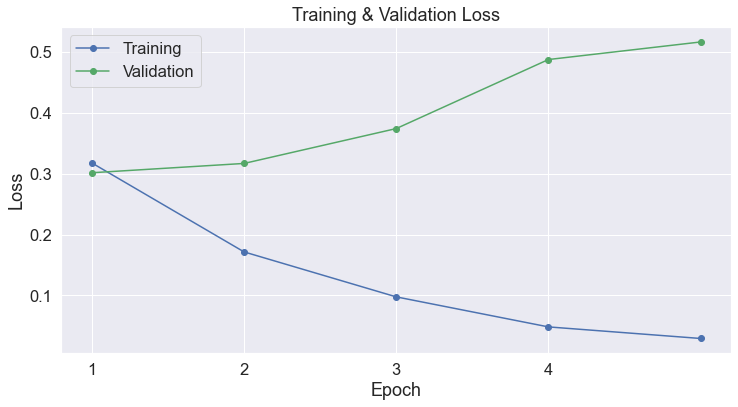

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [20]:
import pandas as pd

df = pd.read_csv("data/twitter-2016test-BD.txt", delimiter='\t', header=None, names=['topic','label','tweet','id'])

print('Number of test sentences: {:,}\n'.format(df.shape[0]))

test_tweet = df.tweet.values
test_topic = df.topic.values
y_test = df.label.values

test_labels=[]
label_dict = {'negative':0,'positive':1}

for label in y_test:
  test_labels.append(label_dict[label])


Number of test sentences: 10,551



In [21]:
input_ids,attention_masks,token_type_ids,labels = processdata(test_topic,test_tweet,test_labels)

 
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks,token_type_ids,labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

F:\anaconda\envs\lab\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing

In [22]:
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def test(model,prediction_dataloader): 

  total_test_acc  = 0
  total_F1_Score = 0
  total_precision = 0
  total_recall = 0

  for batch_idx, (pair_token_ids, mask_ids,token_type_ids,y) in enumerate(prediction_dataloader):
    pair_token_ids = pair_token_ids.to(device)
    mask_ids = mask_ids.to(device)
    labels = y.to(device)
    token_type_ids=token_type_ids.to(device)

    loss, prediction = model(pair_token_ids, 
                             token_type_ids=token_type_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()


    acc = accuracy(prediction, labels)

    f1 = metrics.f1_score(labels.cpu(), torch.argmax(prediction, -1).cpu(), average='binary')
    precision = precision_score(labels.cpu(), torch.argmax(prediction, -1).cpu(), average="binary")
    recall = recall_score(labels.cpu(), torch.argmax(prediction, -1).cpu(), average="binary")

    total_test_acc  += acc.item()
    total_F1_Score += f1
    total_precision += precision
    total_recall += recall
  
  test_acc  = total_test_acc/len(prediction_dataloader)
  test_f1 = total_F1_Score/len(prediction_dataloader)
  test_precision = total_precision/len(prediction_dataloader)
  test_recall = total_recall/len(prediction_dataloader)


  print(f'test_acc: {test_acc:.4f}')
  print(f'f1 Score: {test_f1:.4f}')
  print(f'precision: {test_precision:.4f}')
  print(f'recall: {test_recall:.4f}')

# Evaluation

In [23]:
test(model,prediction_dataloader)

F:\anaconda\envs\lab\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anaconda\envs\lab\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anaconda\envs\lab\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\anaconda\envs\lab\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to 

test_acc: 0.8969
f1 Score: 0.8496
precision: 0.8372
recall: 0.8918
